In [ ]:
# Source - https://github.com/sre-customer-training/lab1-estadistica-descriptiva

__author__ = "Andres M. Correa"
__copyright__ = "BSD 3-Clause License"
__credits__ = []
__license__ = "BSD"
__version__ = "3"
__maintainer__ = "Andres M. Correa"
__email__ = "amcorrea0@gmail.com"
__status__ = "Labs for SRE"

# Nivel 2: Tendencias, Dispersión y Series de Tiempo

**Escenario:** Ahora somos analistas de ventas de una tienda online. Tenemos datos de todo un año. 

**Objetivo SRE:** Entender que los datos cambian con el tiempo (estacionalidad) y que el promedio de un año no sirve para saber qué pasó un martes específico. Introduciremos la Desviación Estándar como medida de "estabilidad".

## Generador de Datos (Ventas Anuales)
Guarda esto como generador_ventas.py. Simula estacionalidad (fines de semana se vende más).

```
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generar_ventas_anuales():
    # Fechas: 1 año completo
    fechas = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
    
    data = []
    for fecha in fechas:
        # Base de venta
        venta_base = 1000
        
        # Estacionalidad: Fin de semana (5=Sab, 6=Dom) vende 50% más
        if fecha.weekday() >= 5:
            venta_base *= 1.5
            
        # Tendencia: Las ventas suben ligeramente a fin de año
        mes = fecha.month
        venta_base += (mes * 50) 
        
        # Ruido aleatorio (Variabilidad normal del negocio)
        ruido = np.random.normal(0, 200) # Media 0, Desviación 200
        venta_final = max(0, int(venta_base + ruido))
        
        data.append([fecha, venta_final])
        
    df = pd.DataFrame(data, columns=['Fecha', 'Ventas'])
    df.to_csv('../datos/datos_ventas_anual.csv', index=False)
    print("✅ Archivo '../datos/datos_ventas_anual.csv' generado (365 días).")

if __name__ == "__main__":
    generar_ventas_anuales()
```



## Notebook Nivel 2: Análisis de Tendencia y Volatilidad

**Bloque 1: Carga y Visualización Lineal**

*Concepto:* Ver los datos crudos. En SRE, esto es ver el gráfico de CPU "serrucho" (con picos y valles constantes).

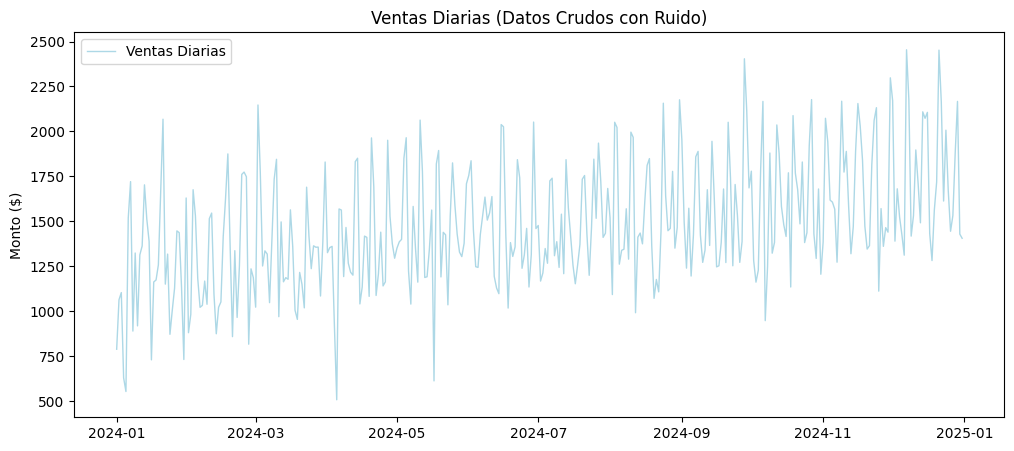

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../datos/datos_ventas_anual.csv', parse_dates=['Fecha'])
df.set_index('Fecha', inplace=True) # Importante para Series de Tiempo

# Visualización cruda
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Ventas'], label='Ventas Diarias', color='lightblue', linewidth=1)
plt.title('Ventas Diarias (Datos Crudos con Ruido)')
plt.ylabel('Monto ($)')
plt.legend()
plt.show()

**Bloque 2: Suavizado (Media Móvil)**

*Concepto:* El "Rolling Window". Como hay mucho ruido diario, usamos el promedio de los últimos 7 días para ver la tendencia real. Analogía SRE: "No me alertes si la CPU sube un segundo. Alértame si el promedio de 5 minutos es alto."

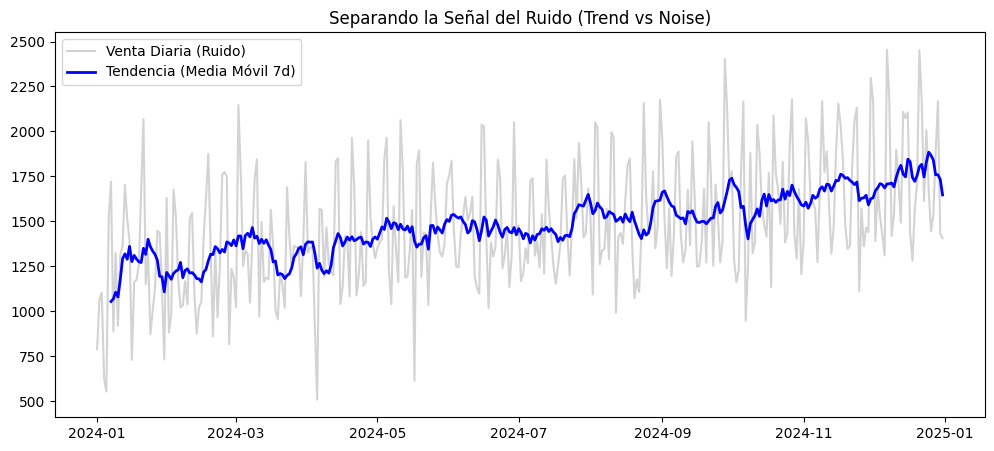

Lección SRE: La línea azul es la 'salud' real del servicio. La gris es el ruido momentáneo.


In [12]:
# Calcular Media Móvil de 7 días (Weekly Rolling Average)
df['Media_Movil_7d'] = df['Ventas'].rolling(window=7).mean()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Ventas'], color='lightgray', label='Venta Diaria (Ruido)')
plt.plot(df.index, df['Media_Movil_7d'], color='blue', linewidth=2, label='Tendencia (Media Móvil 7d)')
plt.title('Separando la Señal del Ruido (Trend vs Noise)')
plt.legend()
plt.show()

print("Lección SRE: La línea azul es la 'salud' real del servicio. La gris es el ruido momentáneo.")

**Bloque 3: Medidas de Dispersión (Estabilidad)**

*Concepto:* Desviación Estándar. Es una medida estadística que indica cuánto varían o se dispersan los datos respecto a su promedio. 

![Desviación Estándar](../images/desviacion-estandar.png)

* **Desviación Baja:** Sistema predecible (Gráfico estrecho).

* **Desviación Alta:** Sistema caótico (Gráfico ancho y plano).


In [13]:
media = df['Ventas'].mean()
std_dev = df['Ventas'].std()
coef_variacion = (std_dev / media) * 100

print(f"Promedio de Ventas: ${media:.2f}")
print(f"Desviación Estándar: ${std_dev:.2f}")
print(f"Coeficiente de Variación: {coef_variacion:.2f}%")

print("\nInterpretación SRE:")
if coef_variacion < 15:
    print("✅ El sistema es estable y predecible.")
else:
    print("⚠️ El sistema es volátil. Es difícil definir SLAs estrictos aquí.")

Promedio de Ventas: $1476.89
Desviación Estándar: $345.47
Coeficiente de Variación: 23.39%

Interpretación SRE:
⚠️ El sistema es volátil. Es difícil definir SLAs estrictos aquí.


**Bloque Final Nivel 2: La Anatomía de la Volatilidad**

*Objetivo:* Tomar los datos de ventas (o latencia) y dibujar su "silueta". Pintaremos la zona donde cae el 68% de los datos (1 Desviación Estándar) para mostrar visualmente qué es "comportamiento estándar", basado en una distribución normal.

--- RANGOS DE NORMALIDAD (Regla Empírica) ---
Zona Segura (68% de los datos): Entre 1131 y 1822
Zona de Alerta (>2 Sigmas): Fuera de 786 - 2168


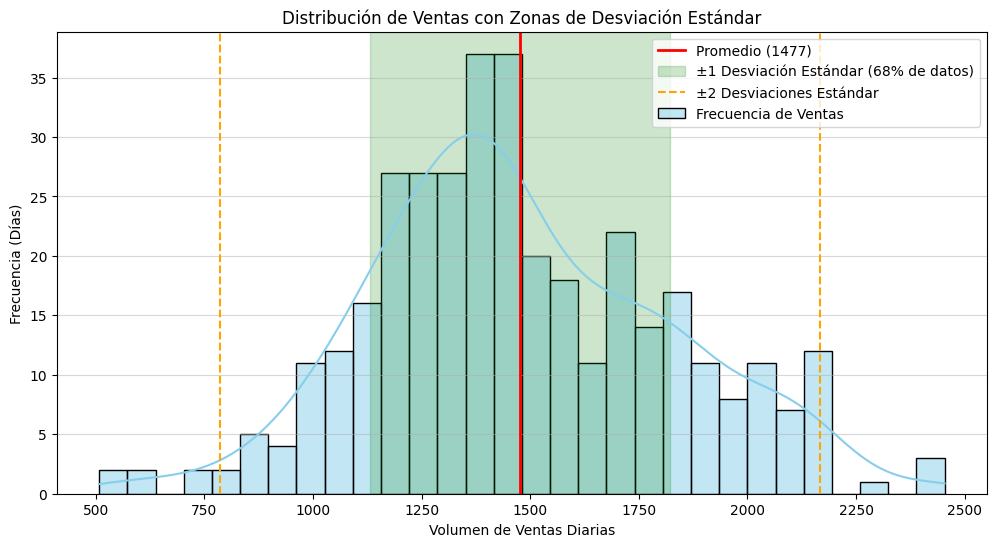

In [14]:
# Definimos los límites de 1 y 2 Desviaciones Estándar
sigma_1_upper = media + std_dev
sigma_1_lower = media - std_dev
sigma_2_upper = media + (2 * std_dev)
sigma_2_lower = media - (2 * std_dev)

print(f"--- RANGOS DE NORMALIDAD (Regla Empírica) ---")
print(f"Zona Segura (68% de los datos): Entre {sigma_1_lower:.0f} y {sigma_1_upper:.0f}")
print(f"Zona de Alerta (>2 Sigmas): Fuera de {sigma_2_lower:.0f} - {sigma_2_upper:.0f}")

# 2. El Gráfico Maestro
plt.figure(figsize=(12, 6))

# A. Histograma y Curva de Densidad (KDE)
sns.histplot(df['Ventas'], kde=True, color="skyblue", bins=30, label='Frecuencia de Ventas')

# B. Línea del Promedio (Centro de gravedad)
plt.axvline(media, color='red', linestyle='-', linewidth=2, label=f'Promedio ({media:.0f})')

# C. Sombrear la zona de 1 Desviación Estándar (El "cuerpo" de la campana)
plt.axvspan(sigma_1_lower, sigma_1_upper, color='green', alpha=0.2, label='±1 Desviación Estándar (68% de datos)')

# D. Líneas de 2 Desviaciones Estándar (Frontera de anomalía)
plt.axvline(sigma_2_lower, color='orange', linestyle='--', linewidth=1.5)
plt.axvline(sigma_2_upper, color='orange', linestyle='--', linewidth=1.5, label='±2 Desviaciones Estándar')

# Decoración
plt.title('Distribución de Ventas con Zonas de Desviación Estándar')
plt.xlabel('Volumen de Ventas Diarias')
plt.ylabel('Frecuencia (Días)')
plt.legend()
plt.grid(axis='y', alpha=0.5)

plt.show()

 ## Explicación

**La Montaña Azul:** Es la forma real de nuestros datos. Si es picuda y alta, somos muy estables. Si es plana y ancha, somos impredecibles.

**La Zona Verde (±1 $\sigma$):** Representa "un día normal en la oficina". Estadísticamente, el 68% de los días caerán aquí. Si una métrica está aquí, no despiertes a nadie.

**Las Líneas Naranjas (±2 $\sigma$):** Son la frontera. Todo lo que esté fuera de estas líneas ocurre menos del 5% de las veces. Aquí es donde empezamos a investigar si pasó algo raro (Black Friday, caída de red, etc.).

***¡Con este cierre visual, el concepto de "Desviación Estándar" deja de ser una fórmula matemática y se convierte en una herramienta visual de decisión!***